
# AAI612: Deep Learning & its Applications

*Notebook 4.1: American Sign Language with Convolution**



# Convolutional Neural Networks

In the previous week, we built and trained a simple model to classify ASL images. The model was able to learn how to correctly classify the training dataset with very high accuracy, but, it did not perform nearly as well on validation dataset. This behavior of not generalizing well to non-training data is called [overfitting](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html), and in this section, we will introduce a popular kind of model called a [convolutional neural network](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) that is especially good for reading images and classifying them.

## Objectives

* Prep data specifically for a CNN
* Create a more sophisticated CNN model, understanding a greater variety of model layers
* Train a CNN model and observe its performance

## Loading and Preparing the Data

The below cell contains the data preprocessing techniques we learned in the previous labs. Review it and execute it before moving on:

In [1]:
import tensorflow.keras as keras
import pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Load in our data from CSV files
train_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

## Reshaping Images for a CNN

In the last exercise, the individual pictures in our dataset are in the format of long lists of 784 pixels:

In [ ]:
x_train.shape, x_valid.shape

((27455, 784), (7172, 784))

In this format, we don't have all the information about which pixels are near each other. Because of this, we can't apply convolutions that will detect features. Let's reshape our dataset so that they are in a 28x28 pixel format. This will allow our convolutions to associate groups of pixels and detect important features.

Note that for the first convolutional layer of our model, we need to have not only the height and width of the image, but also the number of [color channels](https://www.photoshopessentials.com/essentials/rgb/). Our images are grayscale, so we'll just have 1 channel.

That means that we need to convert the current shape `(27455, 784)` to `(27455, 28, 28, 1)`. As a convenience, we can pass the [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html#numpy.reshape) method a `-1` for any dimension we wish to remain the same, therefore:

In [ ]:
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

In [ ]:
x_train.shape

(27455, 28, 28, 1)

In [ ]:
x_valid.shape

(7172, 28, 28, 1)

In [ ]:
x_train.shape, x_valid.shape

((27455, 28, 28, 1), (7172, 28, 28, 1))

## Creating a Convolutional Model

These days, many data scientists start their projects by borrowing model properties from a similar project. Assuming the problem is not totally unique, there's a great chance that people have created models that will perform well which are posted in online repositories like [TensorFlow Hub](https://www.tensorflow.org/hub) and the [NGC Catalog](https://ngc.nvidia.com/catalog/models). Today, we'll provide a model that will work well for this problem.

<img src="https://github.com/harmanani/AAI612/blob/main/Week4/images/cnn.png?raw=1" width=180 />

We covered many of the different kinds of layers in the lecture, and we will go over them all here with links to their documentation. When in doubt, read the official documentation (or ask [stackoverflow](https://stackoverflow.com/)).

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)

<img src="https://github.com/harmanani/AAI612/blob/main/Week4/images/conv2d.png?raw=1" width=300 />

These are our 2D convolutional layers. Small kernels will go over the input image and detect features that are important for classification. Earlier convolutions in the model will detect simple features such as lines. Later convolutions will detect more complex features. Let's look at our first Conv2D layer:
```Python
model.add(Conv2D(75 , (3,3) , strides = 1 , padding = 'same'...)
```
75 refers to the number of filters that will be learned. (3,3) refers to the size of those filters. Strides refer to the step size that the filter will take as it passes over the image. Padding refers to whether the output image that's created from the filter will match the size of the input image.

### [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Like normalizing our inputs, batch normalization scales the values in the hidden layers to improve training. [Read more about it in detail here](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/).

### [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)

<img src="https://github.com/harmanani/AAI612/blob/main/Week4/images/maxpool2d.png?raw=1" width=300 />
Max pooling takes an image and essentially shrinks it to a lower resolution. It does this to help the model be robust to translation (objects moving side to side), and also makes our model faster.

### [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

<img src="https://github.com/harmanani/AAI612/blob/main/Week4/images/dropout.png?raw=1" width=360 />
Dropout is a technique for preventing overfitting. Dropout randomly selects a subset of neurons and turns them off, so that they do not participate in forward or backward propagation in that particular pass. This helps to make sure that the network is robust and redundant, and does not rely on any one area to come up with answers.    

### [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

Flatten takes the output of one layer which is multidimensional, and flattens it into a one-dimensional array. The output is called a feature vector and will be connected to the final classification layer.

### [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

We have seen dense layers before in our earlier models. Our first dense layer (512 units) takes the feature vector as input and learns which features will contribute to a particular classification. The second dense layer (24 units) is the final classification layer that outputs our prediction.

## Summarizing the Model

This may feel like a lot of information, but don't worry. It's not critical that to understand everything right now in order to effectively train convolutional models. Most importantly we know that they can help with extracting useful information from images, and can be used in classification tasks.

Here, we summarize the model we just created. Notice how it has fewer trainable parameters than the model in the previous notebook:

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 75)          │             750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 28, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 75)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 50)          │          33,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 50)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 25)            │          11,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 7, 7, 25)            │             100 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         205,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,049 (1.01 MB)

 Trainable params: 263,749 (1.01 MB)

 Non-trainable params: 300 (1.17 KB)

## Compiling the Model

We'll compile the model just like before:

In [ ]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

## Training the Model

Despite the very different model architecture, the training looks exactly the same. Run the cell below to train for 20 epochs and let's see if the accuracy improves:

In [ ]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 106s 121ms/step - accuracy: 0.7633 - loss: 0.8091 - val_accuracy: 0.9027 - val_loss: 0.3407
Epoch 2/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 99s 116ms/step - accuracy: 0.9937 - loss: 0.0201 - val_accuracy: 0.8721 - val_loss: 0.5996
Epoch 3/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 141s 115ms/step - accuracy: 0.9963 - loss: 0.0105 - val_accuracy: 0.9340 - val_loss: 0.2253
Epoch 4/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 146s 120ms/step - accuracy: 0.9982 - loss: 0.0052 - val_accuracy: 0.9381 - val_loss: 0.2740
Epoch 5/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 137s 115ms/step - accuracy: 0.9989 - loss: 0.0035 - val_accuracy: 0.9545 - val_loss: 0.1473
Epoch 6/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 143s 116ms/step - accuracy: 0.9988 - loss: 0.0042 - val_accuracy: 0.9579 - val_loss: 0.1307
Epoch 7/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 143s 117ms/step - accuracy: 0.9998 - loss: 7.8593e-04 - val_accuracy: 0.9572 - val_loss: 0.1268
Epoch 8/20
858/858 ━━━━━━━━━━━━━━━━━━━━ 143s 118ms/step - accuracy: 0.999

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


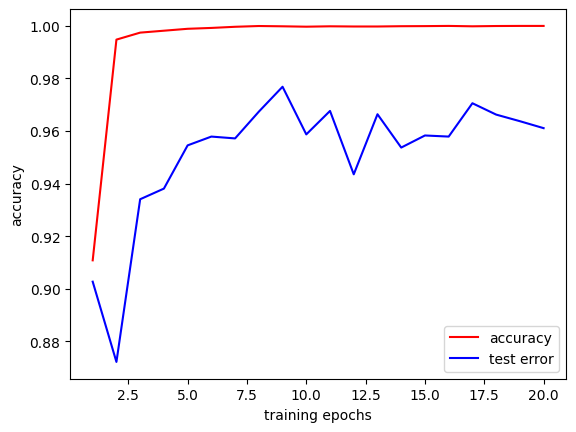

In [ ]:
chart_x = range(1,21)
chart_y_train = history.history['accuracy']
chart_y_test = history.history['val_accuracy']
print(history.history.keys())
import matplotlib.pyplot as plt

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',label='accuracy')
    plt.plot(chart_x, chart_y_test, 'b-',
    label='test error')
    #plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
plot_learning()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 112s 491ms/step - accuracy: 0.6405 - loss: 1.2501 - val_accuracy: 0.1276 - val_loss: 2.9459
Epoch 2/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 137s 475ms/step - accuracy: 0.9961 - loss: 0.0232 - val_accuracy: 0.7242 - val_loss: 0.8722
Epoch 3/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 139s 462ms/step - accuracy: 0.9989 - loss: 0.0086 - val_accuracy: 0.9275 - val_loss: 0.2492
Epoch 4/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 142s 463ms/step - accuracy: 0.9995 - loss: 0.0049 - val_accuracy: 0.9037 - val_loss: 0.3190
Epoch 5/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 142s 464ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9558 - val_loss: 0.1325
Epoch 6/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 140s 457ms/step - accuracy: 0.9987 - loss: 0.0044 - val_accuracy: 0.9357 - val_loss: 0.2180
Epoch 7/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 141s 454ms/step - accuracy: 0.9992 - loss: 0.0038 - val_accuracy: 0.9149 - val_loss: 0.3430
Epoch 8/50
215/215 ━━━━━━━━━━━━━━━━━━━━ 99s 461ms/step - accuracy: 0.9984 - 

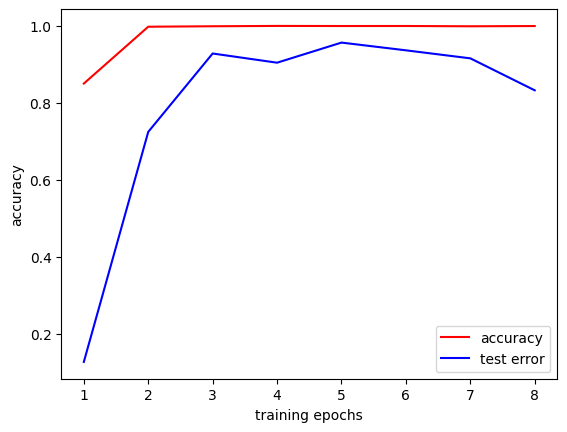

In [ ]:

import tensorflow.keras as keras
import pandas as pd
import ssl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
import matplotlib.pyplot as plt


ssl._create_default_https_context = ssl._create_unverified_context

# Load in our data from CSV files
train_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("https://raw.githubusercontent.com/harmanani/AAI612/main/Week4/asl_data/sign_mnist_valid.csv")

# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate out our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # Added optimizer
# Increase epochs, and batch size. Added early stopping callback
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=50, batch_size=128, verbose=1, validation_data=(x_valid, y_valid), callbacks=[callback])

chart_x = range(1,len(history.history['accuracy'])+1)
chart_y_train = history.history['accuracy']
chart_y_test = history.history['val_accuracy']
print(history.history.keys())

def plot_learning():
    plt.plot(chart_x, chart_y_train, 'r-',label='accuracy')
    plt.plot(chart_x, chart_y_test, 'b-',
    label='test error')
    #plt.axis([0, len(chart_x), 0.0, 1.0])
    plt.xlabel('training epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()
plot_learning()


## Discussion of Results

It looks like this model is significantly improved! The training accuracy is very high, and the validation accuracy has improved as well. This is a great result, as all we had to do was swap in a new model.

You may have noticed the validation accuracy jumping around. This is an indication that our model is still not generalizing perfectly. Fortunately, there's more that we can do. Let's talk about it in the next lecture.

## Summary

In this section, we utilized several new kinds of layers to implement a CNN, which performed better than the more simple model used in the last section. Hopefully the overall process of creating and training a model with prepared data is starting to become even more familiar.

## Next

In the last several sections you have focused on the creation and training of models. In order to further improve performance, you will now turn your attention to *data augmentation*, a collection of techniques that will allow your models to train on more and better data than what you might have originally at your disposal.